 Imports

In [1]:
import h5py
import numba
import numpy as np
import pandas as pd
import scipy.integrate
import matplotlib as mpl
import matplotlib.pyplot as plt
from hoki.utils.exceptions import HokiFormatError
from pylab import cm
from scipy.optimize import fminbound

Data

In [2]:
event_types = ["Ia", "IIP", "II", "Ib", "Ic", "LGRB", "PISNe"]

data = h5py.File(f"/Users/dillon/Desktop/data.h5", "r")
DTD = data['DTD']

observations = data['observations']

In [3]:
file = h5py.File(f"/Users/dillon/Desktop/split_output.h5", "r")
SFH = file['star_form_hist']

In [4]:
obs_Ia = observations['Ia']
obs_CCSN = observations['CCSN']
obs_LGRB = observations['LGRB']
obs_PISN = observations['PISN']

obs_BBH = observations['BBH']
obs_BNS = observations['BNS']
obs_BHNS = observations['BHNS']

Constants 

In [5]:
time_bins = np.arange(6.0, 11.1, 0.1)
linear_time_edges = np.append([0.0], 10**np.arange(6.05, 11.15, 0.1))
linear_time_intervals = np.diff(linear_time_edges)
metallicity_names = ["zem5", "zem4", "z001","z002", "z003", "z004", "z006", "z008", "z010", "z014", "z020", "z030", "z040"]
metallicity_values = np.array([0.00001, 0.0001, 0.001, 0.002, 0.003, 0.004, 0.006, 0.008, 0.010, 0.014, 0.020, 0.030, 0.040])
event_types = ["Ia", "IIP", "II", "Ib", "Ic", "LGRB", "PISNe", "low_mass"]
all_names = ['log_age', 'Ia', 'IIP', 'II', 'Ib', 'Ic', 'LGRB', 'PISNe', 'low_mass', 'e_Ia', 'e_IIP', 'e_II', 'e_Ib', 'e_Ic', 'e_LGRB', 
             'e_PISNe', 'e_low_mass', 'age_yrs']
current_time = 13.799e9
BPASS_METALS = ["10$^{-5}$", "10$^{-4}$", "0.001", "0.002", "0.003", "0.004", "0.006", "0.008", "0.010", "0.014", "0.020", "0.030", "0.040"]


Colormap 

In [6]:
NUM_COLORS = len(BPASS_METALS)
cmap = plt.get_cmap('coolwarm')
bounds = np.linspace(0, NUM_COLORS, NUM_COLORS + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

CSPEventRate class

In [7]:
class CSPEventRate:
    """
    Object to calculate event rates using metallicity specific stellar formation histories.

    Parameters
    ----------
    data_path (str) : folder containing the BPASS data files (in units #events per bin)
    binary (bool) : whether singular or binary systems are used (default = 'True' --> binary only)
    
    Attributes
    ----------
    bpass_rates (pandas.DataFrame) : shape (51, (8, 13)) - BPASS delay time distributions in #events/yr/M_\odot per metallicity - 
        usage: rates.loc[log_age, (type, metallicity)]
    """
    def __init__(self, data_path, binary=True):
        self.bpass_rates = rates_all_z(data_path, binary=binary) / (1e6 * linear_time_intervals[:, None])
        
        # shape (8, 13, 51) [event_type, metallicity, time_bin] - self._numpy_bpass_rates[0] = 'Ia' rates for each metallicity at 51 time points
        self._numpy_bpass_rates = self.bpass_rates[event_types].T.to_numpy().reshape((len(event_types), 13, 51))
        
    def grid_over_time(self, SFH_list, time_points, event_type_list, nr_time_bins, return_time_edges=False):
        """
        Grid calculator to calculate event rates for the given BPASS event types for the given SFH

        Parameters
        ----------
        SFH_list (ndarray) : shape (N, 13, M) [nr_sfh, metalllicities, time_points] - list of N stellar formation histories divided into BPASS
            metallicity bins, over lookback time points with length M.
        time_points (ndarray) : shape (M) - array of lookback time points at which the SFH is given in the SFH_list
        event_type_list (list(str)) : list of BPASS event types - available types include: Ia, IIP, II, Ib, Ic, LGRB, PISNe, or low_mass
        nr_time_bins (int) : number of time bins in which to divide the lookback time
        return_time_edges (bool) : if 'True', returns the edges of the lookback time bins (default = 'False')

        Returns
        -------
        event_rate_list (ndarray) : shape (N, 13, nr_events, nr_time_bins) - array containing the event rates per galaxy (N), per metallicity (13),
            per event type (nr_events) and per time bins (nr_time_bins)
            if `return_time_edges=True`, returns a numpy array containing the event rates and the edges: out[0]=event_rates, out[1]=time_edges
        """
        nr_sfh = SFH_list.shape[0]
        nr_events = len(event_type_list)
        time_edges = np.linspace(0, current_time, nr_time_bins+1)
        bpass_rates =  self._numpy_bpass_rates[[event_types.index(event) for event in event_type_list]]  # rates for each Z at 51 time points
        event_rate_list = np.zeros((nr_sfh, 13, nr_events, nr_time_bins), dtype=np.float64)
        
        for sfh in range(nr_sfh):
            event_rate_list[sfh] = self._grid_rate_calculator_over_time(bpass_rates, SFH_list[sfh], time_points, nr_time_bins)

        if return_time_edges:
            return np.array([event_rate_list, time_edges], dtype=object)
        else:
            return event_rate_list

    @staticmethod
    @numba.njit(parallel=True, cache=True)
    def _grid_rate_calculator_over_time(bpass_rates, SFH, time_points, nr_time_bins):
        """
        Grid rate calculator to calculate the event rates for specific BPASS rates over time

        Parameters
        ----------
        bpass_rates (ndarray) : shape (M, 13, 51) [event_type, metallicity, time_bin] - array containing the BPASS event rates per event type (M),
            metallicity and BPASS time bin.
        SFH (ndarray) : shape (13, N) [metallicity, SFH_time_sampling_points] - SFH for each metallicity at the time_points
        time_points (ndarray) : time points at which the SFH is sampled (N)
        nr_time_bins (int) : number of time points in which to split the lookback time (final binning)

        Returns
        -------
        event_rates (ndarray) : shape (13, M, nr_time_bins) - array containing the event rates per metallicity (13) per event type (M) per time bins
        """
        nr_event_type = bpass_rates.shape[0]
        event_rates = np.empty((13, nr_event_type, nr_time_bins), dtype=np.float64)
        time_edges = np.linspace(0, current_time, nr_time_bins+1)
        mass_per_bin_list = np.empty((13, nr_time_bins), dtype=np.float64)

        for index in numba.prange(13):  # calculating mass per bin for each metallicity
            mass_per_bin_list[index] = _optimised_mass_per_bin(time_points, SFH[index], time_edges, sample_rate=25)

        for counter in numba.prange(13):  # looping over metallicities
            for count in numba.prange(nr_event_type):  # looping over event type
                event_rate = _over_time(np.ones(nr_time_bins)*metallicity_values[counter], mass_per_bin_list[counter], time_edges,
                                              bpass_rates[count])
                event_rates[counter][count] = event_rate/np.diff(time_edges)
        return event_rates

CSPEventRate functions

In [8]:
def rates_all_z(data_path, binary=True):
    """
    Loads the BPASS supernova event files.
    
    Parameters
    ----------
    data_path (str) : filepath to the folder containing the BPASS data (no backslash needed on the end)
    binary (bool) : if `True`, loads the binary files (default = 'True')
    
    Returns
    -------
    bpass_rates (pandas.DataFrame) : shape (51, (8, 13)) (log_age, (event_types, metallicity) - dataframe containing BPASS number of events per 
        metallicity per type
        usage: rates.loc[log_age, (type, metallicity)]
    """
    star = "bin" if binary else "sin"  # determines population type

    arrays = [metallicity_values, event_types]  # create output dataframe with shape (13, 8) (metallicity, event type)
    
    columns = pd.MultiIndex.from_product(arrays, names=["Metallicity", "Event Type"])
    

    rates = pd.DataFrame(index=time_bins, columns=columns, dtype=np.float64)
    rates.index.name = "log_age"

    for num, metallicity in enumerate(metallicity_names):
        data = pd.read_csv(f"{data_path}/supernova-{star}-imf135_300.{metallicity}.dat", sep=r"\s+", names=all_names, engine='python')
        data = data.loc[:, slice(event_types[0], event_types[-1])]
        rates.loc[:, (metallicity_values[num], slice(None))] = data.to_numpy()

    bpass_rates = rates.swaplevel(0, 1, axis=1)  # swaps metallicity and event type
    return bpass_rates

In [9]:
@numba.njit(cache=True)
def _optimised_mass_per_bin(time_points, sfh, time_edges, sample_rate=25):
    """
    Mass per bin calculation from grid data

    Parameters
    ----------
    time_point (ndarray) : shape (N) - time points at which the SFH is sampled
    sfh (ndarray) : shape (N) - SFH at the time_point samples
    time_edges (ndarray) : shape (M) - edges of the bins in which the mass per bin is wanted in yrs.
    sample_rate (int) : number of samples to take to use for the trapezodial integration (default = 25)

    Returns
    -------
    out (ndarray) : shape (M-1) - array of the mass per time bin
    """
    l = len(time_edges)-1  # equivalent to nr_bins
    out = np.empty(l)
    for num in range(l):  # subsample and interpolate for inbetween values
        s = 0
        x = np.linspace(time_edges[num], time_edges[num+1], sample_rate)
        y = np.interp(x, time_points, sfh)
        for N in range(1, len(x)):
            s += (x[N] - x[N-1]) * (y[N] + y[N-1])
        out[num] = s/2
    return out

In [10]:
@numba.njit(cache=True)
def _get_bin_index(x, edges):
    """
    Gets the bin number given the edges.

    Parameters
    ----------
    x (float) : value where the bin number is needed to be known
    edges (ndarray) : array with the edges of the histogram
    
    Returns
    -------
    out (int) : bin index of x

    """
    if x < edges[0] or x > edges[-1]:  # checks if x is within the edge ranges
        raise HokiFormatError("x outside of range")

    out = 0
    if x == edges[-1]:  # if x is equal to the last bin, return len-2
        out = len(edges) - 2

    for i, val in enumerate(edges):
        if val > x:  # x larger than bin, return answer
            out = i - 1
            break
    return int(out)

In [11]:
@numba.njit(cache=True)
def _integral(x1, x2, edges, values, bin_width):
    """
    Perfoms an intergral over histogram-like binned data.

    Parameters
    ----------
    x1 (float) : lower bound of the integration
    x2 (float) : upper bound of the integration
    edges (ndarray) : edges of the bins
    values (ndarray) : values in each bin
    bin_width (ndarray) : width of each bin

    Returns
    -------
    total (float) : integral between 'x1' and 'x2'

    """
    lower_bin = _get_bin_index(x1, edges)
    upper_bin = _get_bin_index(x2, edges)

    total = 0

    # Values within the same bin. Return fraction of the bin
    if lower_bin == upper_bin:
        total = values[lower_bin] * (x2 - x1)
    else:
        # Add part of the lower and upper bin to the total
        ledge = lower_bin + 1
        total += (values[lower_bin] * (edges[ledge] - x1))
        total += (values[upper_bin] * (x2 - edges[upper_bin]))

        # Add any remaining bins to the total
        if ledge < upper_bin:
            total += np.sum(bin_width[ledge:upper_bin]
                            * values[ledge:upper_bin])

    return total

In [12]:
@numba.njit(cache=True)
def _over_time(Z_per_bin, mass_per_bin, time_edges, bpass_rates):
    """
    Calculates the events rates per bin over the given bin edges.

    Parameters
    ----------
    Z_per_bin (ndarray) : shape N - array containing the metallicity values in each time bin
    mass_per_bin (ndarray) : shape N - array containing the mass per time bin
    time_edges (ndarray) : shape N+1 - bin edges of Z_per_bin and mass_per_bin
    bpass_rates (ndarray) : shape (13, 51) [metallicity, log_age] - 2D array containing the event rates for all BPASS metallicities over time 
        in BPASS bins
        usage: bpass_rates[0][2] (gives the event rate at the metallicity 0.00001 and a log_age of 6.2)

    Returns
    -------
    event_rate (ndarray) : shape N - number of events per bin
    """
    Z_index_per_bin = np.array([np.argmin(np.abs(Z - metallicity_values)) for Z in Z_per_bin])
    event_rate = np.zeros(len(mass_per_bin))

    for count in range(len(mass_per_bin)):
        t = time_edges[count + 1]
        for num in range(0, count + 1):
            p1 = t - time_edges[num]
            p2 = t - time_edges[num + 1]
            bin_events = _integral(p2, p1, linear_time_edges, bpass_rates[Z_index_per_bin[count]], linear_time_intervals)
            event_rate[num] += bin_events * mass_per_bin[count]
    return event_rate

Lookback Time

In [13]:
@np.vectorize
def calc_LB(z, omega0, omega1, hubble):
    '''
    Calculates the lookback time according to Hobbs.

    Parameters:
    z : float
        The redshift at which you want to calculate the lookback
    omega0 : float
        The Matter density parameter (0.3111 Planck 2018)
    omega1 : float
        The dark energy density parameter (0.6889 Planck 2018)
    hubble : float
        The hubble parameters (0.6766 Planck 2018)
    '''
    def func(x):
        E = np.sqrt(omega0*(1+x)**3 + omega1)
        return 1/((1+x)*E)
    # can be simplified by already doing the extra coefficient calculations
    t_hubble = (1/(100*hubble))*3.0856776*10**19
    return t_hubble *scipy.integrate.quad(func, 0, z)[0]/(60*60*24*365.2388526)

lookback_time = calc_LB(SFH.attrs['redshift'], 0.3111, 0.6889, 0.6766)

Redshift 

In [14]:
@np.vectorize
def approxZ(LB, omega0, omega1, hubble):
    """Internal function to convert a redshift into a lookback time.

    Parameters:
    LB : float
        lookback time in yrs
    omega0 : float
        the matter density parameter (0.3111 Planck 2018)
    omega1 : float
        The dark energy density parameter (0.6889 Planck 2018)
    hubble : float
        the hubble parameter (0.6766 Planck 2018)
    """
    zmin = 1e-8
    zmax = 1000
    ztol = 1e-8
    maxfun = 5000
    f = lambda z : abs(calc_LB(z, omega0, omega1, hubble) - LB)

    z, _, _, _ = fminbound(f, zmin, zmax, maxfun=maxfun, full_output=1, xtol=ztol)
    return z

In [15]:
SFH_input = SFH[:].reshape(1, SFH.shape[0], SFH.shape[1])*1e9  #Transform SFR from per Myr^-3 to Gpc-3$
er_csp = CSPEventRate('/Users/dillon/Desktop/bpass_v2.2.1_imf135_300', binary=True)

In [16]:
out, edges = er_csp.grid_over_time(SFH_input, lookback_time, event_types, 100, return_time_edges=True)
out = out[0]

In [17]:
redshift_edges = approxZ(edges, 0.3111, 0.6889, 0.6766)

SFH Input

Text(0, 0.5, 'CSFRH [$M_{\\odot} yr^{-1} Mpc^{-3}$]')

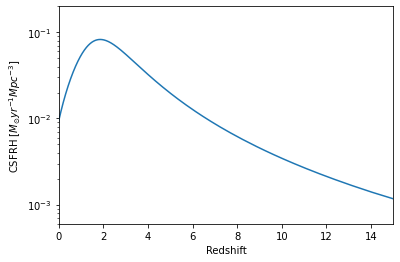

In [18]:
plt.plot(SFH.attrs['redshift'], np.sum(SFH, axis=0))
plt.yscale('log')
plt.xlim(0, 15)
plt.ylim(6e-4, 2e-1)
plt.xlabel('Redshift')
plt.ylabel('CSFRH [$M_{\odot} yr^{-1} Mpc^{-3}$]')

### Electromagnetic Transients 

Total Event Rate Densities

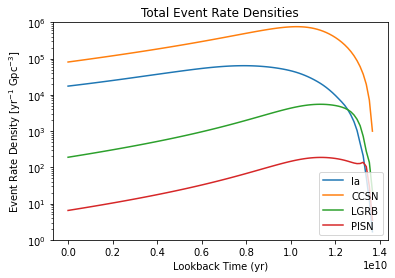

In [19]:
CCSN_rates = np.sum(out[:,1:5], axis=0).sum(axis=0)

plt.plot(edges[:-1],  np.sum(out[:,0], axis=0), label='Ia')
plt.plot(edges[:-1],  CCSN_rates, label='CCSN')
plt.plot(edges[:-1],  np.sum(out[:,5], axis=0), label='LGRB')
plt.plot(edges[:-1],  np.sum(out[:,6], axis=0), label='PISN')
plt.yscale('log')
plt.ylim(1e0, 1e6)
plt.xlabel('Lookback Time (yr)')
plt.ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
plt.title('Total Event Rate Densities')
plt.legend()
plt.show()

Text(0, 0.5, 'Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$')

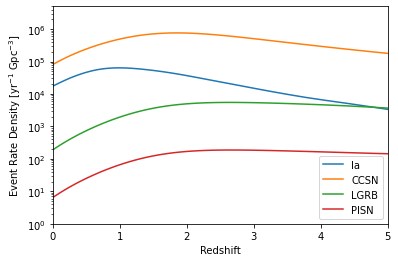

In [20]:
plt.plot(redshift_edges[:-1],  np.sum(out[:,0], axis=0), label='Ia')
plt.plot(redshift_edges[:-1],  CCSN_rates, label='CCSN')
plt.plot(redshift_edges[:-1],  np.sum(out[:,5], axis=0), label='LGRB')
plt.plot(redshift_edges[:-1],  np.sum(out[:,6], axis=0), label='PISN')
plt.yscale('log')
plt.ylim(1e0, 5e6)
plt.xlim(0,5)
plt.legend()
plt.xlabel('Redshift')
plt.ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")

Compare with the results from the Briel paper 

In [21]:
event_rates = data['event_rates']

In [22]:
h = event_rates.attrs['h']
omega_M = event_rates.attrs['omega_M']
omega_L = event_rates.attrs['omega_L']

Ia

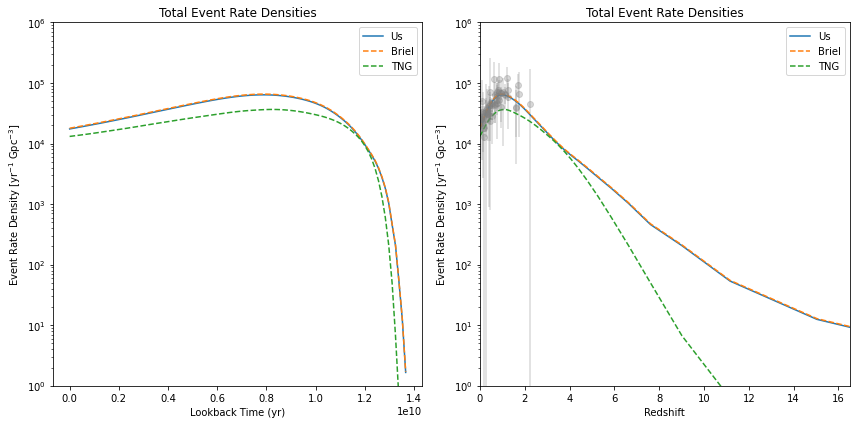

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6)) 


axs[0].plot(edges[:-1], np.sum(out[:, 0], axis=0), label='Us')
axs[0].plot(edges[:-1], np.sum(event_rates['empirical']["Ia"], axis=0), '--', label='Briel')
axs[0].plot(edges[:-1], np.sum(event_rates['TNG']["Ia"], axis=0), '--', label='TNG')
axs[0].set_yscale('log')
axs[0].set_ylim(1e0, 1e6)
axs[0].set_xlabel('Lookback Time (yr)')
axs[0].set_ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
axs[0].set_title('Total Event Rate Densities')
axs[0].legend()

axs[1].plot(redshift_edges[:-1], np.sum(out[:, 0], axis=0), label='Us')
axs[1].plot(redshift_edges[:-1], np.sum(event_rates['empirical']["Ia"], axis=0), '--', label='Briel')
axs[1].plot(redshift_edges[:-1], np.sum(event_rates['TNG']["Ia"], axis=0), '--', label='TNG')

axs[1].errorbar(np.array(obs_Ia['mean_z']),
            np.array(obs_Ia['rate'])*h**3, 
            xerr=[obs_Ia['lower_z'],obs_Ia['upper_z']],
            yerr=[obs_Ia['lower_rate']*h**3, obs_Ia['upper_rate']*h**3],
            fmt="o",
            ms=6,
            alpha=0.3,
            color="grey")

axs[1].set_yscale('log')
axs[1].set_ylim(1e0, 1e6)
axs[1].set_xlim(0, 16.5)
axs[1].set_xlabel('Redshift')
axs[1].set_ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
axs[1].set_title('Total Event Rate Densities')
axs[1].legend()

plt.tight_layout()  
plt.show()

CCSN

In [24]:
CCSN = {}
CCSN["empirical"] =  np.sum(event_rates['empirical']["II"],axis=0)
CCSN["empirical"] += np.sum(event_rates['empirical']["IIP"],axis=0)
CCSN["empirical"] += np.sum(event_rates['empirical']["Ib"],axis=0)
CCSN["empirical"] += np.sum(event_rates['empirical']["Ic"],axis=0)

In [44]:
CCSN_TNG = {}
CCSN_TNG["TNG"] =  np.sum(event_rates['TNG']["II"],axis=0)
CCSN_TNG["TNG"] += np.sum(event_rates['TNG']["IIP"],axis=0)
CCSN_TNG["TNG"] += np.sum(event_rates['TNG']["Ib"],axis=0)
CCSN_TNG["TNG"] += np.sum(event_rates['TNG']["Ic"],axis=0)

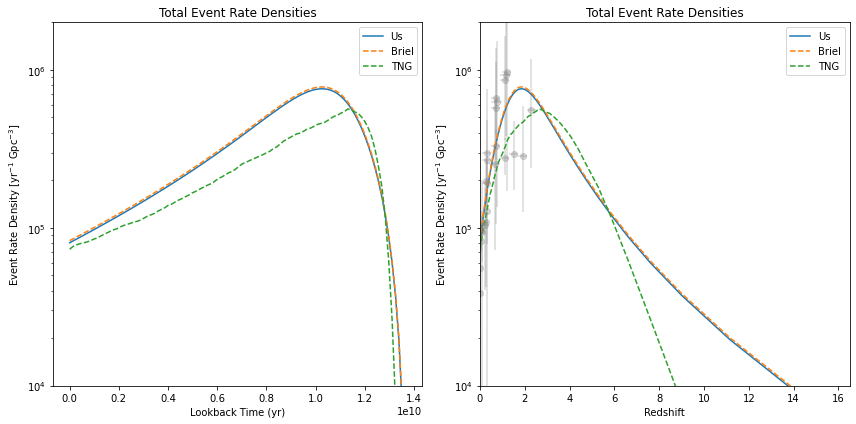

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6)) 

axs[0].plot(edges[:-1], CCSN_rates, label='Us')
axs[0].plot(edges[:-1], CCSN['empirical'], '--', label='Briel')
axs[0].plot(edges[:-1], CCSN_TNG['TNG'], '--', label='TNG')
axs[0].set_yscale('log')
axs[0].set_ylim(1e4, 2e6)
axs[0].set_xlabel('Lookback Time (yr)')
axs[0].set_ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
axs[0].set_title('Total Event Rate Densities')
axs[0].legend()

axs[1].plot(redshift_edges[:-1], CCSN_rates, label='Us')
axs[1].plot(redshift_edges[:-1], CCSN['empirical'], '--', label='Briel')
axs[1].plot(redshift_edges[:-1], CCSN_TNG['TNG'], '--', label='TNG')

axs[1].errorbar(np.array(obs_CCSN['mean_z']),
            np.array(obs_CCSN['rate'])*h**3, 
            xerr=[obs_CCSN['lower_z'],obs_CCSN['upper_z']],
            yerr=[obs_CCSN['lower_rate']*h**3, obs_CCSN['upper_rate']*h**3],
            fmt="o",
            ms=6,
            alpha=0.3,
            color="grey")

axs[1].set_yscale('log')
axs[1].set_ylim(1e4, 2e6)
axs[1].set_xlim(0, 16.5)
axs[1].set_xlabel('Redshift')
axs[1].set_ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
axs[1].set_title('Total Event Rate Densities')
axs[1].legend()

plt.tight_layout() 
plt.show()

LGRB

Note that there is no post processing on the rates 

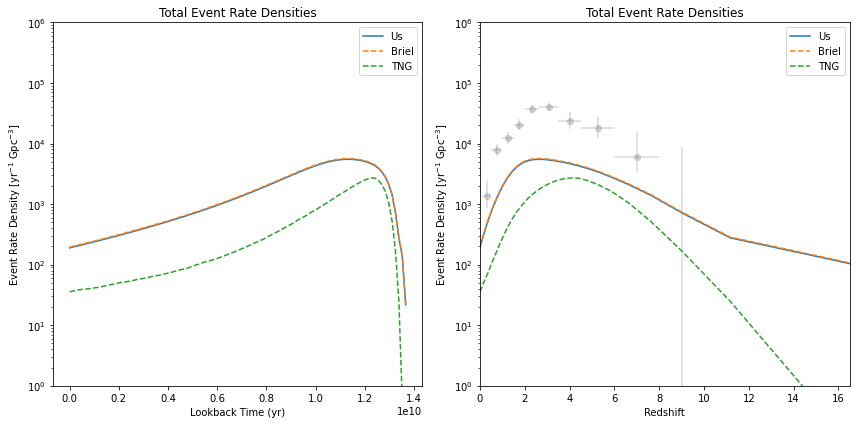

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6)) 

axs[0].plot(edges[:-1], np.sum(out[:, 5], axis=0), label='Us')
axs[0].plot(edges[:-1], np.sum(event_rates['empirical']["LGRB"], axis=0), '--', label='Briel')
axs[0].plot(edges[:-1], np.sum(event_rates['TNG']["LGRB"], axis=0), '--', label='TNG')
axs[0].set_yscale('log')
axs[0].set_ylim(1e0, 1e6)
axs[0].set_xlabel('Lookback Time (yr)')
axs[0].set_ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
axs[0].set_title('Total Event Rate Densities')
axs[0].legend()

axs[1].plot(redshift_edges[:-1], np.sum(out[:, 5], axis=0), label='Us')
axs[1].plot(redshift_edges[:-1], np.sum(event_rates['empirical']["LGRB"], axis=0), '--', label='Briel')
axs[1].plot(redshift_edges[:-1], np.sum(event_rates['TNG']["LGRB"], axis=0), '--', label='TNG')

axs[1].errorbar(np.array(obs_LGRB['mean_z']),
            np.array(obs_LGRB['rate'])*h**3, 
            xerr=[obs_LGRB['lower_z'],obs_LGRB['upper_z']],
            yerr=[obs_LGRB['lower_rate']*h**3, obs_LGRB['upper_rate']*h**3],
            fmt="o",
            ms=6,
            alpha=0.3,
            color="grey")

axs[1].set_yscale('log')
axs[1].set_ylim(1e0, 1e6)
axs[1].set_xlim(0, 16.5)
axs[1].set_xlabel('Redshift')
axs[1].set_ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
axs[1].set_title('Total Event Rate Densities')
axs[1].legend()

plt.tight_layout() 
plt.show()

PISNe

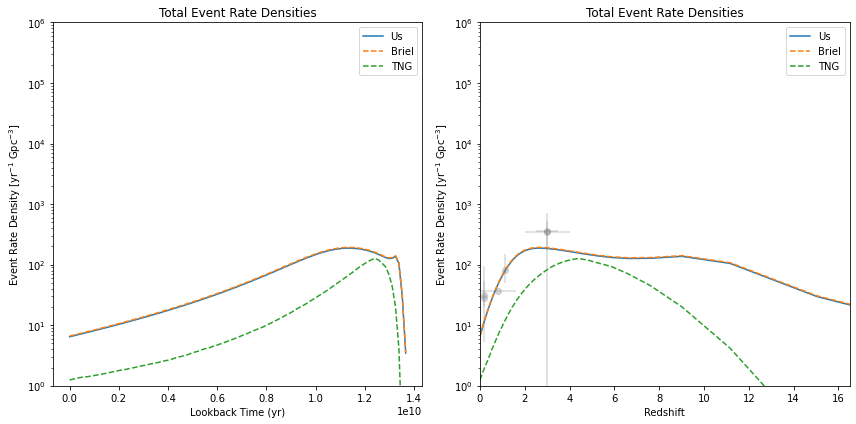

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6)) 

axs[0].plot(edges[:-1], np.sum(out[:, 6], axis=0), label='Us')
axs[0].plot(edges[:-1], np.sum(event_rates['empirical']["PISNe"], axis=0), '--', label='Briel')
axs[0].plot(edges[:-1], np.sum(event_rates['TNG']["PISNe"], axis=0), '--', label='TNG')
axs[0].set_yscale('log')
axs[0].set_ylim(1e0, 1e6)
axs[0].set_xlabel('Lookback Time (yr)')
axs[0].set_ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
axs[0].set_title('Total Event Rate Densities')
axs[0].legend()

axs[1].plot(redshift_edges[:-1], np.sum(out[:, 6], axis=0), label='Us')
axs[1].plot(redshift_edges[:-1], np.sum(event_rates['empirical']["PISNe"], axis=0), '--', label='Briel')
axs[1].plot(redshift_edges[:-1], np.sum(event_rates['TNG']["PISNe"], axis=0), '--', label='TNG')

axs[1].errorbar(np.array(obs_PISN['mean_z']),
            np.array(obs_PISN['rate'])*h**3, 
            xerr=[obs_PISN['lower_z'],obs_PISN['upper_z']],
            yerr=[obs_PISN['lower_rate']*h**3, obs_PISN['upper_rate']*h**3],
            fmt="o",
            ms=6,
            alpha=0.3,
            color="grey")

axs[1].set_yscale('log')
axs[1].set_ylim(1e0, 1e6)
axs[1].set_xlim(0, 16.5)
axs[1].set_xlabel('Redshift')
axs[1].set_ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
axs[1].set_title('Total Event Rate Densities')
axs[1].legend()

plt.tight_layout()  
plt.show()

### Gravitational Wave Transients 

In [28]:
GW_events = ["BNS", "BHNS", "BBH"]

In [29]:
# the number of bins of the final event rate calculation
nr_time_bins = 100


# split the final lookback time into the requested number of bins
# er_csp.now contains the hubble time in the given cosmology when initiated
time_edges = np.linspace(0, current_time, nr_time_bins+1)

rates = {}
for event in GW_events:
    
    event_dtd = np.empty((13,51))

    # extract the DTD of the event type for all metallicities
    # It's important to give the metallicities in the same order as BPASS_METALLICITIES
    for i, Z in enumerate(metallicity_names):
        event_dtd[i] = DTD[event][Z]
    
    # reshape to include an additional dimension
    event_dtd = event_dtd.reshape(1,13,51)
    
    # this function requires the following input:
    # DTD (1x13x51) [event_type x metallicity x BPASS time bins]
    # SFH (13x100) [metallicites x SFH lookback time]
    # lookback_time (100) [SFH lookback time]
    # nr_time_bins (100) [nr_bins to split the final event rate time into]
    # t_hubble (1) [hubble time]
    rates[event] = er_csp._grid_rate_calculator_over_time(event_dtd, SFH_input[0], lookback_time, nr_time_bins)        

Total Event Rate Densities

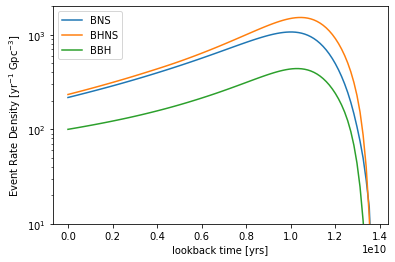

In [30]:
#fig = plt.figure(figsize=(10,10))

for i in rates:
    plt.plot(edges[:-1],  np.sum(rates[i], axis=0)[0], label=i)

plt.yscale('log')
plt.ylim(1e1, 2e3)
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
plt.legend()
plt.show()

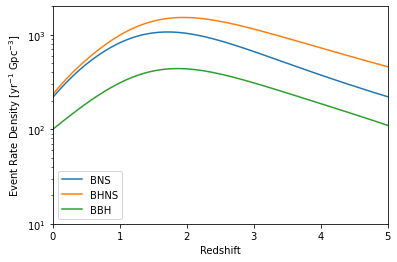

In [31]:
for i in rates:
    plt.plot(redshift_edges[:-1],  np.sum(rates[i], axis=0)[0], label=i)

plt.yscale('log')
plt.xlim(0,5)
plt.ylim(1e1, 2e3)
plt.xlabel('Redshift')
plt.ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
plt.legend()
plt.show()

Compare with Briel

BBH

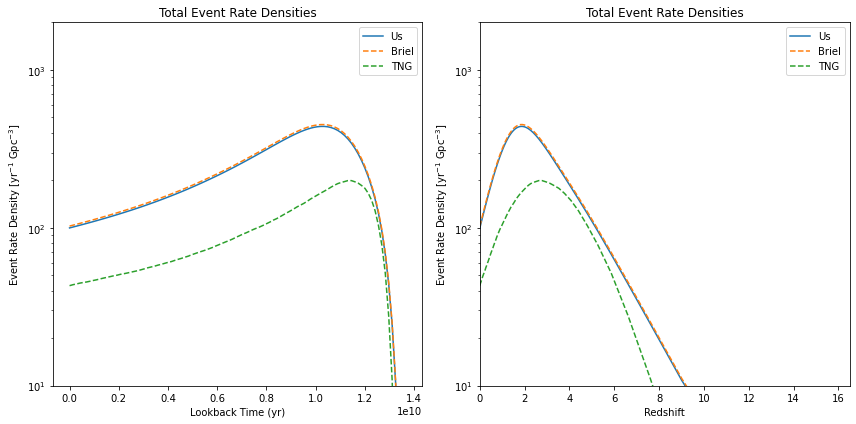

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6)) 

axs[0].plot(edges[:-1], np.sum(rates['BBH'], axis=0)[0], label='Us')
axs[0].plot(edges[:-1], np.sum(event_rates['empirical']["BBH"], axis=0), '--', label='Briel')
axs[0].plot(edges[:-1], np.sum(event_rates['TNG']["BBH"], axis=0), '--', label='TNG')
axs[0].set_yscale('log')
axs[0].set_ylim(1e1, 2e3)
axs[0].set_xlabel('Lookback Time (yr)')
axs[0].set_ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
axs[0].set_title('Total Event Rate Densities')
axs[0].legend()

axs[1].plot(redshift_edges[:-1], np.sum(rates['BBH'], axis=0)[0], label='Us')
axs[1].plot(redshift_edges[:-1], np.sum(event_rates['empirical']["BBH"], axis=0), '--', label='Briel')
axs[1].plot(redshift_edges[:-1], np.sum(event_rates['TNG']["BBH"], axis=0), '--', label='TNG')
axs[1].set_yscale('log')
axs[1].set_ylim(1e1, 2e3)
axs[1].set_xlim(0, 16.5)
axs[1].set_xlabel('Redshift')
axs[1].set_ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
axs[1].set_title('Total Event Rate Densities')
axs[1].legend()

plt.tight_layout()  
plt.show()

BNS

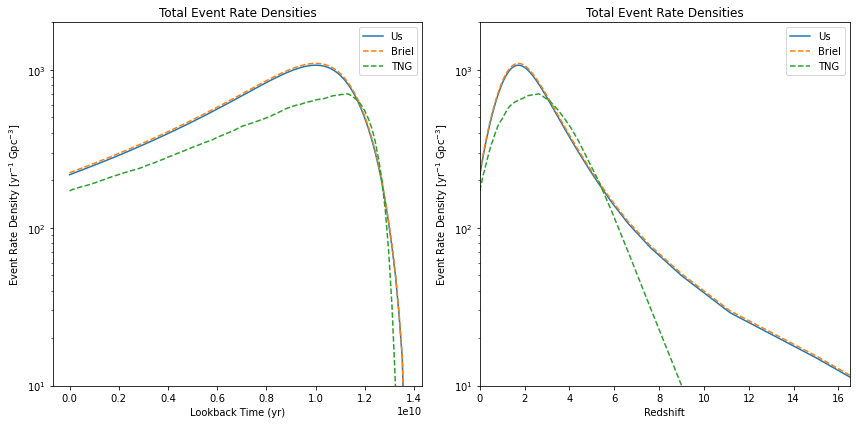

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6)) 

axs[0].plot(edges[:-1], np.sum(rates['BNS'], axis=0)[0], label='Us')
axs[0].plot(edges[:-1], np.sum(event_rates['empirical']["BNS"], axis=0), '--', label='Briel')
axs[0].plot(edges[:-1], np.sum(event_rates['TNG']["BNS"], axis=0), '--', label='TNG')
axs[0].set_yscale('log')
axs[0].set_ylim(1e1, 2e3)
axs[0].set_xlabel('Lookback Time (yr)')
axs[0].set_ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
axs[0].set_title('Total Event Rate Densities')
axs[0].legend()

axs[1].plot(redshift_edges[:-1], np.sum(rates['BNS'], axis=0)[0], label='Us')
axs[1].plot(redshift_edges[:-1], np.sum(event_rates['empirical']["BNS"], axis=0), '--', label='Briel')
axs[1].plot(redshift_edges[:-1], np.sum(event_rates['TNG']["BNS"], axis=0), '--', label='TNG')
axs[1].set_yscale('log')
axs[1].set_ylim(1e1, 2e3)
axs[1].set_xlim(0, 16.5)
axs[1].set_xlabel('Redshift')
axs[1].set_ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
axs[1].set_title('Total Event Rate Densities')
axs[1].legend()

plt.tight_layout()  
plt.show()

BHNS

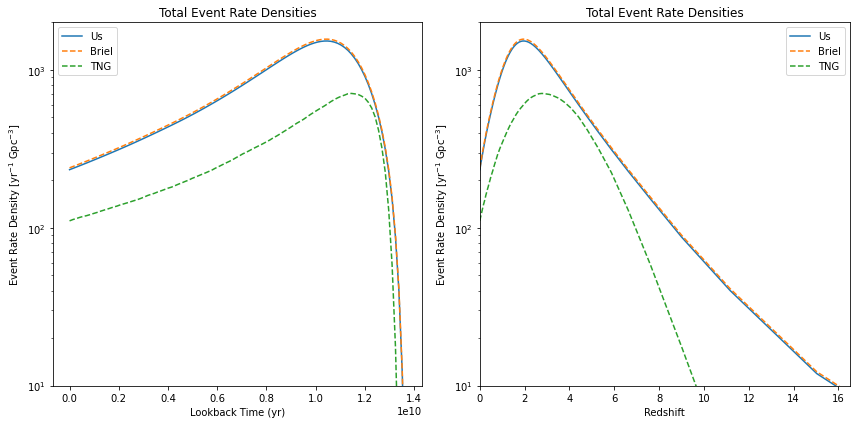

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  

axs[0].plot(edges[:-1], np.sum(rates['BHNS'], axis=0)[0], label='Us')
axs[0].plot(edges[:-1], np.sum(event_rates['empirical']["BHNS"], axis=0), '--', label='Briel')
axs[0].plot(edges[:-1], np.sum(event_rates['TNG']["BHNS"], axis=0), '--', label='TNG')
axs[0].set_yscale('log')
axs[0].set_ylim(1e1, 2e3)
axs[0].set_xlabel('Lookback Time (yr)')
axs[0].set_ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
axs[0].set_title('Total Event Rate Densities')
axs[0].legend()

axs[1].plot(redshift_edges[:-1], np.sum(rates['BHNS'], axis=0)[0], label='Us')
axs[1].plot(redshift_edges[:-1], np.sum(event_rates['empirical']["BHNS"], axis=0), '--', label='Briel')
axs[1].plot(redshift_edges[:-1], np.sum(event_rates['TNG']["BHNS"], axis=0), '--', label='TNG')
axs[1].set_yscale('log')
axs[1].set_ylim(1e1, 2e3)
axs[1].set_xlim(0, 16.5)
axs[1].set_xlabel('Redshift')
axs[1].set_ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
axs[1].set_title('Total Event Rate Densities')
axs[1].legend()

plt.tight_layout() 
plt.show()